In [442]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Introduction

Using publicly available data on credit card purchases made by the Birmingham City Council we intend to find interesing patterns and insights from these transactions. We will try to find anomalous purchases so that we can flag any potential fraudulent behavior at the transaction level. We will apply clustering techniques as well as anomaly detection and forecasting.

The purpose of this analysis is to understand underlying patterns in credit card movement through data to hopefully uncover irregular purchases which may lead to further auditing and investigation.

## Data Collection

The data consists of transactions made each month by the council on corporate

We have multiple Excel spreadsheets from the Birmingham City Council Open Data Portal which we want to aquire the automatically. For this we will get the download links by scraping their website and running multiple HTTP requests to download each table.

In [430]:
def get_data(url):
    """
    Function to scrape download links from data source webpage and
    retrieve file from the download.
    
    Parameters:
    ===========
        url: URL Path to Birmingham Open Data Site
        
    Returns:
        None
    """
    
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    data_resources = soup.find(id = 'dataset-resources')
    resource_list = data_resources.find_all('li', class_='resource-item')
    dl_links = [l.find_all('a', "resource-url-analytics")[0]['href'] for l in resource_list]
    for link in dl_links:
        resp = requests.get(link)
        filename = os.path.join('data', 'raw', link.split('/')[-1])
        output = open(filename, 'wb')
        output.write(resp.content)
        output.close()

In [ ]:
def find_directorate_col(dat):
    """
    Function to find all directorate/merchant type columns to avoid ambiguity
    Parameters:
    ===========
        dat: pandas.DataFrame loaded from Excel file
    Returns:
    ===========
        string: Name of column 
    """
    dcol = dat.columns[dat.columns.str.contains('Directorate|Unnamed')][0]
    return dcol

In [ ]:
def get_clean_table():
    """
    This function does the following data processing steps:
    - Read all downloaded Excel files
    - Filter to relevant columns
    - Rename tables
    - Create on big historical dataset
    """
    cols = ['TRANS DATE', 'CARD NUMBER', 'ORIGINAL GROSS AMT', 'MERCHANT NAME']
    tables = []
    for f in glob('data/raw/*.xls'):
        tab = pd.read_excel(f)
        directorate_col = find_directorate_col(tab)
        select_cols = cols + [directorate_col]
        subtab = tab[select_cols]
        subtab.columns = ['trans_date', 'card_number_id', 'gross_amount', 'merchant', 'category']
        tables.append(subtab)
    return pd.concat(tables)

The following command needs to be executed only once, which will collect and store locally the whole 44 tables

In [ ]:
# pull all Excel Spreadsheets. Run once
# URL = 'https://data.birmingham.gov.uk/dataset/purchase-card-transactions'
# dl_links = get_data(URL)

Once we have gathered the entirety of the data, we will move on to clean the table to create one single matrix with the variables of intereste to us. We will selecte these columns based on what is available for all tables, and what may be relevant for our subsequent analysis.

In [371]:
# Pre-process and merge all spreadsheets
purchases = get_clean_table()

## Data Cleaning

In this section we will identify missing values, ambiguos strings, and number scales.

In [372]:
# Check for missingness
purchases.isna().sum()

trans_date          1
card_number_id      1
gross_amount        1
merchant            1
category          738
dtype: int64

As we can see there is only one entry that has no data in any of the variables. We'll drop this entry.

In [373]:
# Clean Credit Card numbers
purchases['card_number_id'] = purchases['card_number_id'].str.replace('*', '', regex=False)


The merchat/purchase category seems to be quite ambiguous and dirty, so let's have a look at the different values so that we may proceed with a proper cleaning strategy.

In [374]:
# Clean merchant/purchase category
purchases['category'] = purchases['category'].str.lower().fillna('unknown')

In [376]:
purchases['category'].value_counts()

cyp&f schools                   87991
local services                  42431
cyp&f                           24467
corporate resources             12464
adult & communities             12367
development                      4024
unknown                           738
adult social care and health      564
cyp&f                             548
cyp&f                             127
cyo&f                              93
adults & comms                     51
adults                             24
adults & communities               16
corporate procurement               3
                                    1
Name: category, dtype: int64

Since there are mulitple categories that represent the same idea, we will manually recode them in order to reduce the amount of variablity in this feature.

In [624]:
# Recode ambiguous categories
purchases['category'] = purchases['category'].str.strip().replace({'adults': 'adults & communities',
                                          'adults & comms': 'adults & communities',
                                          'adult & communities': 'adults & communities',
                                          'adults': 'adults & communities', 
                                          'adult social care and health': 'adults & communities',
                                          'cyo&f': 'cyp&f schools', 'cyp&f': 'cyp&f schools'})
purchases['category'] = purchases['category'].replace({'corporate procurement': 'corporate resources'})

In [625]:
purchases['category'].value_counts()

cyp&f schools           113226
local services           42431
adults & communities     13022
corporate resources      12467
development               4024
unknown                    738
                             1
Name: category, dtype: int64

Now we save the output data:

In [661]:
# purchases.to_csv('data/output/purchases_clean.csv', index=False)

## Exploratory Data Analysis

Now that we have cleaned the data we will start looking at the distributions and summary statistics of the data at both the transaction and client level.

In [626]:
#Total number of Merchants, couting duplicate or amibiguous namings
purchases.merchant.nunique()

15856

In [627]:
# Total number of unique users, given by credit card number
purchases.card_number_id.nunique()

1523

In [628]:
# Min, Max and Average number of transactions per client
purchases.groupby('card_number_id').count()['merchant'].agg({'mean', 'max', 'min'})

min        1.000000
mean     122.066973
max     2676.000000
Name: merchant, dtype: float64

In [629]:
# Min, Max and Average amount of purchases in GBP
purchases['gross_amount'].agg({'mean', 'max', 'min'})

min    -486980.090000
mean       176.607761
max     280102.230000
Name: gross_amount, dtype: float64

In [630]:
# How many negatives?
sum(purchases['gross_amount'] < 0)/len(purchases)

0.027674830158841153

We see here that the minimum value for all transactions is a negative value. Also, we see that only around 2% of our data consists of negative amounts. These transactions usually reflect an overpayment from the user, which leaves the loaning entity owining money to the customer. We will limit our analysis to only those positive amount transactions since we don't want to mix different behaviors in our analysis.

In [631]:
purchases_pos = purchases[purchases['gross_amount'] > 0].set_index('trans_date')

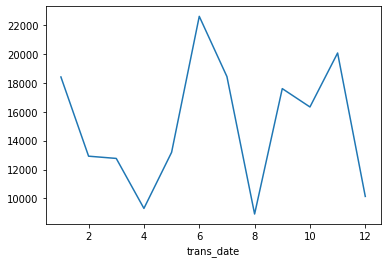

In [632]:
# How many transactions are completed every month for all years
purchases_pos.groupby(purchases_pos.index.month).count()['card_number_id'].plot();

We see here that most transactions happen around January, June, and November.

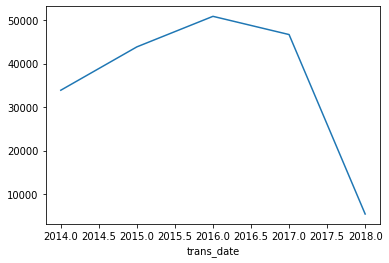

In [633]:
# Is there a growing trend in purchases?
purchases_pos.groupby(purchases_pos.index.year).count()['card_number_id'].plot();

We can see there is a consistent  mildly upward trend on the number of purchases, we a drop on 2018. However, we only have data for 2 months for 2018, which as we saw from the monthly purchases, we are probably missing two more peaks of purchases for that year.

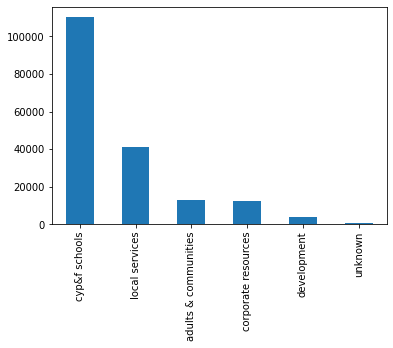

In [634]:
# What are the more common types of transactions?
purchases_pos['category'].value_counts().plot(kind='bar');

## Modeling

At this point we would like to have a look at potential groupings that may arise for each transaction. We will focus mainly on working at the transaction level, and will ignore any clustering by customer, i.e., we don't want to find characteristics about the clients but instead we want to find patterns for each transaction independently.

In [635]:
purchases_pos['month'] = purchases_pos.index.month

In [636]:
# Transform transaction categories into binary indicators
categories_wide = pd.get_dummies(purchases_pos['category'])

purchases_wide = pd.concat([purchases_pos[['gross_amount', 'month']], categories_wide], 1)

### Correlations

Let's have a look at the features correlations.

In [637]:
purchases_wide.corr()

,gross_amount,month,adults & communities,corporate resources,cyp&f schools,development,local services,unknown
gross_amount,1.000000,0.003227,0.007211,0.118165,-0.078679,-0.008995,0.019088,0.003301
month,0.003227,1.000000,-0.011465,0.002662,0.004180,0.000370,0.004481,-0.027906
adults & communities,0.007211,-0.011465,1.000000,-0.073927,-0.343421,-0.040999,-0.148824,-0.016892
corporate resources,0.118165,0.002662,-0.073927,1.000000,-0.336454,-0.040167,-0.145804,-0.016550
cyp&f schools,-0.078679,0.004180,-0.343421,-0.336454,1.000000,-0.186593,-0.677319,-0.076880
development,-0.008995,0.000370,-0.040999,-0.040167,-0.186593,1.000000,-0.080861,-0.009178
local services,0.019088,0.004481,-0.148824,-0.145804,-0.677319,-0.080861,1.000000,-0.033316
unknown,0.003301,-0.027906,-0.016892,-0.016550,-0.076880,-0.009178,-0.033316,1.000000


We can see there are no strong relationships between the variables from our data.

### KMeans Clustering
Using this resulting matrix we want to find any clusters that could emerge to capture any interesting patterns for each transaction.

In [638]:
from sklearn.cluster import KMeans

In [639]:
score_1 = []
range_values = range(1, 10)
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(purchases_wide)
    score_1.append(kmeans.inertia_)

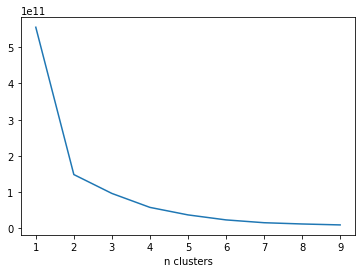

In [640]:
plt.plot(range_values, score_1);
plt.xlabel('n clusters');

Given that two clusters will suffice to group our transactions we go ahead and create these:

In [519]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++',
                max_iter = 300, n_init = 10, random_state = 0)
labels = kmeans.fit_predict(purchases_wide)

In [642]:
purchases_wide['cluster'] = labels

Having two clusters makes sense since there is little information we can get from the current dataset, other than trying to identify anomalous purchases. Therefore, if we think in these terms anoalous vs not anomalous, these two clusters are apporpriate to our goals.

Now let's compare where differences arise between the two determine clusters.

In [643]:
# Sample size
purchases_wide['cluster'].value_counts()

0    180616
1       147
Name: cluster, dtype: int64

The proportion of transactions that are labeled into one of these two groups is quite small, let's see how other variables vary by each cluster.

In [522]:
purchases_wide.groupby('cluster').mean().T

cluster,0,1
gross_amount,150.384545,52796.661224
month,6.562874,6.687075
adults & communities,0.070221,0.000000
corporate resources,0.066810,0.959184
cyp&f schools,0.610306,0.020408
development,0.021809,0.000000
local services,0.227101,0.000000
unknown,0.003754,0.020408


We can say that this clustering algorithm captures a samll number of transactions of large amounts mainly related to Corporate Resources, Schools, and Local Services. We cannot say anything else concerning these transactions, i.e, we cannot say these are stritly fraudulent, although they are unsually large (way above the 176 GBP average per transaction). Also, given that they appear in such low numbers, one may be inclined to say that these purchases are not very common, or in other words, may represent an anomaly from the general behavior. Therefore, we can treat this grouping as a flag for anomaly vs not.

### Anomaly Detection

Another approach we could take to tackle anomalous behavior is to actually fit a Multivariate Normal to the gross amount per transaction to determine if there are outliers. Before we fit this model, the transaction amount needs to be transformed into a logarithmic scale, so that it adjusts to our assumptions.

We will take the cluster identification as a proxy for an anomaly, and then we'll try to capture these outliers with the following Gaussian estimation.

In [647]:
# transform into log scale to adjust to normality assumptions
log_amount = np.log(purchases_wide['gross_amount'])

In [648]:
from scipy.stats import norm
mu, std = norm.fit(log_amount)

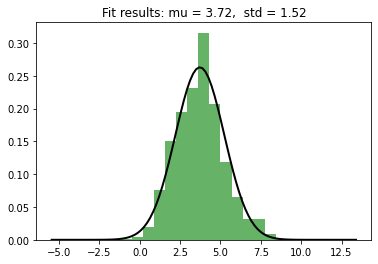

In [649]:
# Plot the histogram.
plt.hist(log_amount, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In order to capture or determine the outliers we need to set a threshold and compare that to the clustering label, since we are treating that as our anomaly label. For thie we will compute Precision and Recall for multiple values of this threshold, in order to determine the best fitting value set on the normal distribution for the purchase amount. This al is assuming the clustering label does correspond to a true state of anomaly.

In [650]:
pval = norm.pdf(log_amount, mu, std)
yval = purchases_wide['cluster'].values

In [651]:
from sklearn.metrics import precision_score, recall_score

F1 = 0
bestF1 = 0
bestEpsilon = 0
erange = np.arange(0, 0.1, 0.0005)

for eps in erange:
    try:
        pred = (pval < eps).astype(int)
        prec = precision_score(yval, pred)
        rec = recall_score(yval, pred)
        F1 = 2*prec*rec/(prec + rec)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    except ZeroDivisionError:
        print('Warning dividing by zero!!') 


/Users/ilanreinstein/Interviews/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ilanreinstein/Interviews/env/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Now that we determined the best threshold to flag anomalies based on our previusly labeled transactions (via clustering) we can compare all of our variables purchases that were flagged by the Anomaly Detection algorithm.

In [656]:
purchases_wide['outlier'] = pval < bestEpsilon
purchases_wide.groupby('outlier').mean().T[:-1]

outlier,False,True
gross_amount,90.603706,3266.145909
month,6.554107,6.828596
adults & communities,0.069048,0.103596
corporate resources,0.064383,0.161986
cyp&f schools,0.625875,0.129110
development,0.022221,0.008904
local services,0.214654,0.594178
unknown,0.003819,0.002226


Again, we can see this other method for anomaly detection gives us similar resutls for the behavior of the transactions. Many high-valued purchases will be flagged, as anomalous, where the majority belong to Local Services. This is however a consrvative approximation, since we do not have proper groun truth on the state of the transactions.

## Forecasting

Another problem that we may want to tackle is to determine future purchase amounts. Given that there are some trends over time we can try and determine unseen credit card behavior, and subsequently flag it as anomalous based on the previous methods, either clusterin or the Normal Distribution.

For simplicity, we'll use Facebook's pre-built Prophet library, which is a widely used library for Time Series Forecasting.

<AxesSubplot:xlabel='trans_date'>

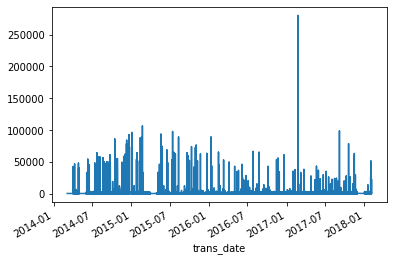

In [583]:
purchases_wide.sort_index()['gross_amount'].plot()

In order for us to make reliable predictions, we need to resample our data so that we get weekly purchase averages. This in turn will give us a more uniform time interval, therefore it is more appropriate to model. Additionally, we can take care of missing values since we are able to interpolate values between time intervals.

In [657]:
weekly_purchases = purchases_wide['gross_amount'].resample(rule = 'W').mean().\
                    interpolate().reset_index().rename(columns = {'trans_date':'ds', 'gross_amount':'y'})



In [658]:
from prophet import Prophet
# Prophet requires columns ds (Date) and y (value)
# weekly_purchases['y'] = np.log(weekly_purchases['y'])
# Make the prophet model and fit on the data
w_prophet = Prophet(changepoint_prior_scale=0.15)
w_prophet.fit(weekly_purchases)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [620]:
w_forecast = w_prophet.make_future_dataframe(periods=52, freq='W')
# Make predictions
w_forecast = w_prophet.predict(w_forecast)

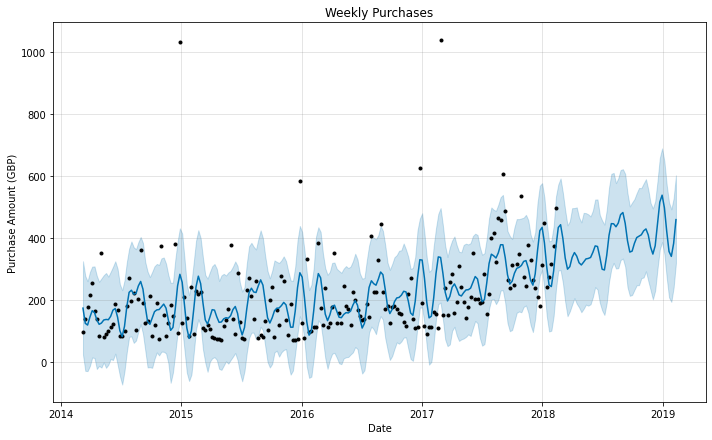

In [621]:
w_prophet.plot(w_forecast, xlabel = 'Date', ylabel = 'Purchase Amount (GBP)')
plt.title('Weekly Purchases');

We see here a number of outliers that exceed the upper predictive interval, i.e., they are well above the average and tend to be very high purchase amounts, which we already determined are anomalous.